## Reddit Posts TF-IDF Analysis
Gulliver Wutz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import string
from nltk.corpus import stopwords
import glob
import re

def clean_texts(texts):
    stops = stopwords.words("english")
    custom_stoplist = ["im", "Im", "I'm", "i'm"]
    stops = stops + custom_stoplist
    final = []
    for text in texts:
        clean_text = remove_stops(text, stops)
        final.append(clean_text)
    return (final)

def remove_stops(text, stops):
    words = str(text).split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def tf_idf_cluster(cleaned_texts, k):
    vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.5,
                                min_df=2,
                                ngram_range = (1,3),
                                stop_words = "english"

                            )
    vectors = vectorizer.fit_transform(cleaned_texts)
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    all_keywords = []

    for post in denselist:
        x=0
        keywords = []
        for word in post:
            if word > 0:
                keywords.append(feature_names[x])
            x=x+1
        all_keywords.append(keywords)

    model = KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1, random_state=16)
    model.fit(vectors)
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    return(order_centroids, terms)

pd.set_option('display.max_colwidth', 500)

In [2]:
# Load Dataset
reddit_posts = pd.read_csv('C:/Users/wutzg/Desktop/Master Thesis/Artifacts/Datasets/reddit_posts_trimmed.csv')

### TF-IDF Post Titles

In [3]:
post_titles = reddit_posts['Title'].tolist()
cleaned_post_titles = clean_texts(post_titles)

In [4]:
k = 6
order_centroids, terms = tf_idf_cluster(cleaned_post_titles, k)

columns = []
for i in range(k):
    columns.append('Cluster ' + str(i))
clusters_df = pd.DataFrame(columns=columns)

for i in range(k):
        column = []
        for ind in order_centroids[i, :10]:
            column.append(terms[ind])
        clusters_df[columns[i]] = column
clusters_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,build,game,play,help,new,art
1,support,mid,game,need,skin,legends
2,vs,win,vs,build,build,league
3,good,best,champ,new,season,league legends
4,season,like,mid,main,player,wild
5,like,build,support,matchup,items,rift
6,best,playing,like,support,best,lol
7,mid,got,season,guys,prestige,wild rift
8,item,new,guys,game,skarner,skin
9,got,ranked,adc,player,like,really


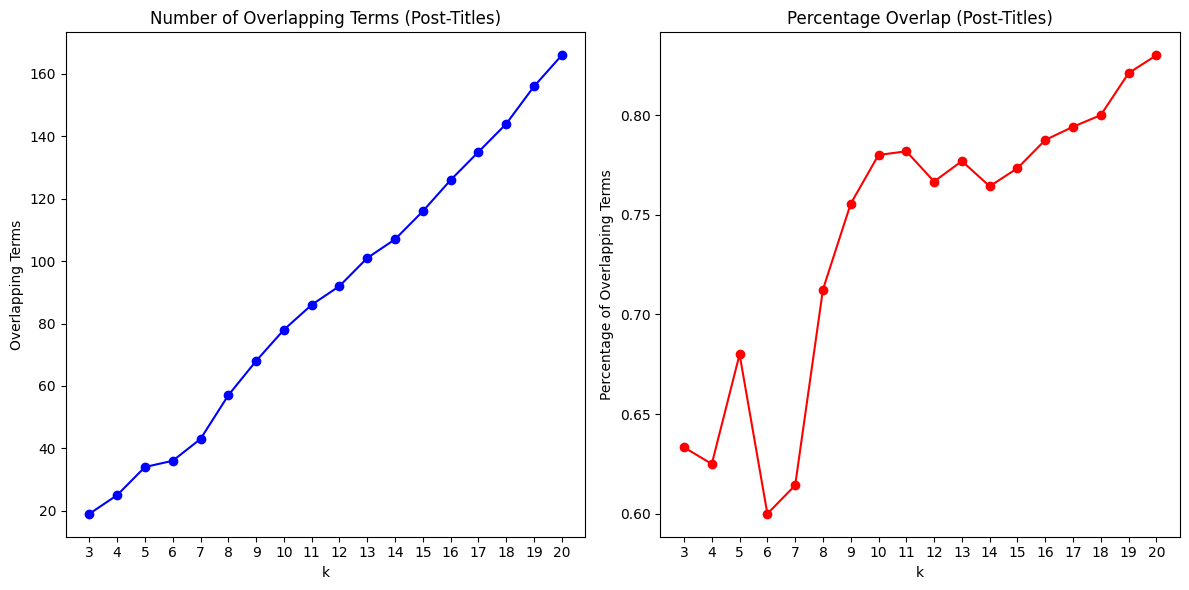

In [5]:
overlap_df = pd.DataFrame(columns=['k', 'duplicates', 'duplicates_per', 'duplicates_top'])

for it in range(18):
    k = 20 - it
    n_duplicates = 0
    top_five_string = ''
    order_centroids, terms = tf_idf_cluster(cleaned_post_titles, k)

    columns = []
    for i in range(k):
        columns.append('Cluster ' + str(i))
    clusters_df = pd.DataFrame(columns=columns)

    for i in range(k):
            column = []
            for ind in order_centroids[i, :10]:
                column.append(terms[ind])
            clusters_df[columns[i]] = column

    clusters_df_terms = clusters_df.values.flatten().tolist()
    for term in clusters_df_terms:
        if clusters_df_terms.count(term) > 1:
            n_duplicates += 1

    counter = Counter(clusters_df_terms)
    top_five = counter.most_common(5)
    for tup in top_five:
        tup_string = (str(tup[0]) + ': ' + str(tup[1]) + ', ')
        top_five_string += tup_string
    top_five_string = top_five_string[:-2]

    new_data = {
                'k': k,
                'duplicates': n_duplicates,
                'duplicates_per': (n_duplicates / len(clusters_df_terms)),
                'duplicates_top': top_five_string
    }

    new_row = pd.DataFrame([new_data])
    overlap_df = pd.concat([overlap_df, new_row], ignore_index=True)

overlap_df['k'] = overlap_df['k'].astype(int)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First line chart for duplicates
axes[0].plot(overlap_df['k'], overlap_df['duplicates'], marker='o', color='b')
axes[0].set_title('Number of Overlapping Terms (Post-Titles)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Overlapping Terms')
axes[0].set_xticks(overlap_df['k']) 

# Second line chart for duplicates percentage
axes[1].plot(overlap_df['k'], overlap_df['duplicates_per'], marker='o', color='r')
axes[1].set_title('Percentage Overlap (Post-Titles)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Percentage of Overlapping Terms')
axes[1].set_xticks(overlap_df['k']) 

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()


In [6]:
overlap_df

,k,duplicates,duplicates_per,duplicates_top
0,20,166,0.830000,"build: 13, new: 12, game: 12, best: 10, like: 9"
1,19,156,0.821053,"new: 12, build: 12, game: 11, best: 9, like: 8"
2,18,144,0.800000,"new: 12, build: 12, game: 11, best: 9, like: 8"
3,17,135,0.794118,"new: 12, build: 12, game: 10, like: 8, best: 8"
4,16,126,0.787500,"new: 12, build: 11, game: 10, best: 8, like: 7"
5,15,116,0.773333,"new: 11, build: 10, game: 9, best: 7, like: 7"
6,14,107,0.764286,"new: 10, build: 9, game: 8, best: 6, like: 6"
7,13,101,0.776923,"new: 10, build: 8, game: 8, play: 5, best: 5"
8,12,92,0.766667,"new: 9, build: 7, game: 7, season: 7, play: 5"
9,11,86,0.781818,"new: 8, build: 7, game: 7, season: 7, play: 5"


### TF-IDF Self-Posts Text

In [7]:
self_posts = reddit_posts[reddit_posts['Is Self-post'] == 1]['Content'].tolist()
cleaned_self_posts = clean_texts(self_posts)

In [8]:
k = 9
order_centroids, terms = tf_idf_cluster(cleaned_self_posts, k)

columns = []
for i in range(k):
    columns.append('Cluster ' + str(i))
clusters_df = pd.DataFrame(columns=columns)

for i in range(k):
        column = []
        for ind in order_centroids[i, :10]:
            column.append(terms[ind])
        clusters_df[columns[i]] = column
clusters_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,xb,game,play,new,build,feel,rate,like,skin
1,like,early,playing,items,damage,feel like,win,feels,like
2,build,team,lane,build,item,like,win rate,really,know
3,got,like,support,season,good,game,games,good,think
4,game,games,champ,like,think,build,pick,think,new
5,know,play,mid,good,know,really,season,damage,got
6,think,playing,know,item,items,good,players,know,guys
7,damage,time,main,know,ap,damage,play,build,riot
8,item,enemy,really,guys,guys,play,game,item,want
9,guys,know,like,think,better,feels,new,ive,best


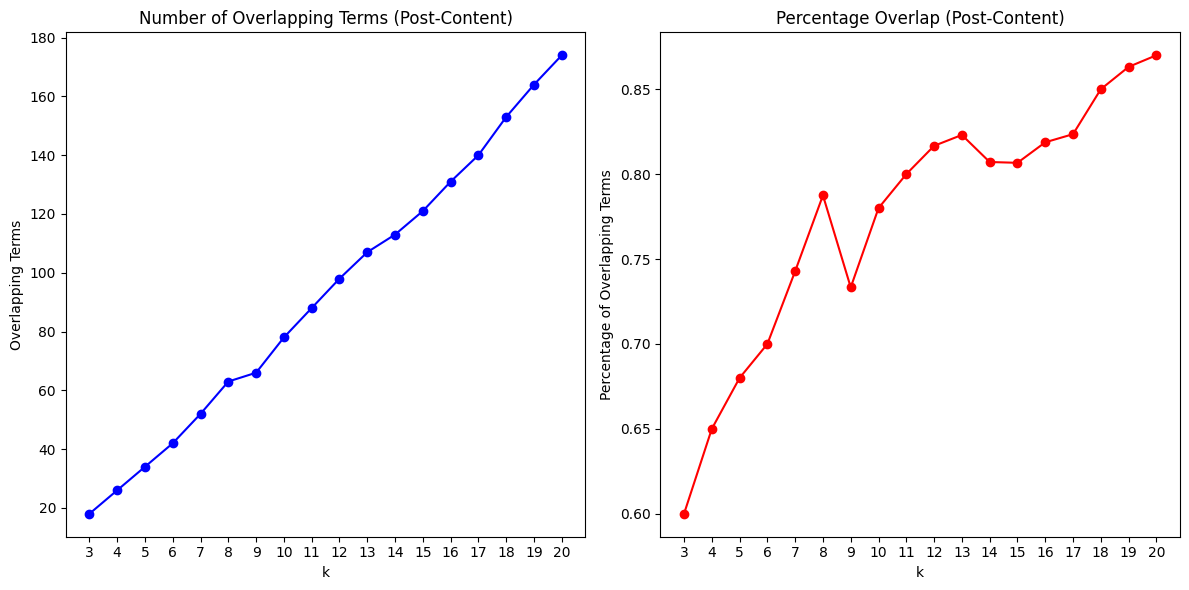

In [9]:
overlap_df = pd.DataFrame(columns=['k', 'duplicates', 'duplicates_per', 'duplicates_top'])

for it in range(18):
    k = 20 - it
    n_duplicates = 0
    top_five_string = ''
    order_centroids, terms = tf_idf_cluster(cleaned_self_posts, k)

    columns = []
    for i in range(k):
        columns.append('Cluster ' + str(i))
    clusters_df = pd.DataFrame(columns=columns)

    for i in range(k):
            column = []
            for ind in order_centroids[i, :10]:
                column.append(terms[ind])
            clusters_df[columns[i]] = column

    clusters_df_terms = clusters_df.values.flatten().tolist()
    for term in clusters_df_terms:
        if clusters_df_terms.count(term) > 1:
            n_duplicates += 1

    counter = Counter(clusters_df_terms)
    top_five = counter.most_common(5)
    for tup in top_five:
        tup_string = (str(tup[0]) + ': ' + str(tup[1]) + ', ')
        top_five_string += tup_string
    top_five_string = top_five_string[:-2]

    new_data = {
                'k': k,
                'duplicates': n_duplicates,
                'duplicates_per': (n_duplicates / len(clusters_df_terms)),
                'duplicates_top': top_five_string
    }

    new_row = pd.DataFrame([new_data])
    overlap_df = pd.concat([overlap_df, new_row], ignore_index=True)

overlap_df['k'] = overlap_df['k'].astype(int)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First line chart for duplicates
axes[0].plot(overlap_df['k'], overlap_df['duplicates'], marker='o', color='b')
axes[0].set_title('Number of Overlapping Terms (Post-Content)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Overlapping Terms')
axes[0].set_xticks(overlap_df['k']) 

# Second line chart for duplicates percentage
axes[1].plot(overlap_df['k'], overlap_df['duplicates_per'], marker='o', color='r')
axes[1].set_title('Percentage Overlap (Post-Content)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Percentage of Overlapping Terms')
axes[1].set_xticks(overlap_df['k']) 

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
overlap_df

,k,duplicates,duplicates_per,duplicates_top
0,20,174,0.870000,"like: 18, know: 13, game: 10, think: 9, really: 9"
1,19,164,0.863158,"like: 17, know: 11, game: 10, think: 9, build: 8"
2,18,153,0.850000,"like: 16, play: 11, know: 10, think: 10, game: 8"
3,17,140,0.823529,"like: 15, play: 11, think: 10, know: 9, game: 7"
4,16,131,0.818750,"like: 14, play: 10, know: 9, think: 9, really: 7"
5,15,121,0.806667,"like: 13, play: 11, think: 8, know: 8, build: 7"
6,14,113,0.807143,"like: 12, play: 9, know: 8, good: 8, think: 7"
7,13,107,0.823077,"like: 11, play: 9, good: 8, know: 7, really: 7"
8,12,98,0.816667,"like: 10, play: 8, good: 8, really: 7, think: 6"
9,11,88,0.800000,"like: 9, play: 7, good: 7, really: 7, know: 6"


### TF-IDF Self-Posts Text Single Patch

In [11]:
self_posts_patch = reddit_posts[(reddit_posts['Is Self-post'] == 1) & (reddit_posts['Patch'] == 14.8)]['Content'].tolist()
cleaned_self_posts_patch = clean_texts(self_posts_patch)

In [12]:
k = 7
order_centroids, terms = tf_idf_cluster(cleaned_self_posts_patch, k)

columns = []
for i in range(k):
    columns.append('Cluster ' + str(i))
clusters_df = pd.DataFrame(columns=columns)

for i in range(k):
        column = []
        for ind in order_centroids[i, :10]:
            column.append(terms[ind])
        clusters_df[columns[i]] = column
clusters_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,build,damage,team,like,skin,game,champion
1,item,like,game,know,like,play,like
2,items,passive,enemy,play,know,like,champions
3,like,ap,games,xb,new,playing,play
4,good,item,play,good,think,games,make
5,ap,health,lane,playing,time,time,game
6,know,items,win,think,want,early,playing
7,ad,think,players,guys,high,know,time
8,better,ability,like,really,riot,really,know
9,play,good,feel,time,really,ive,main


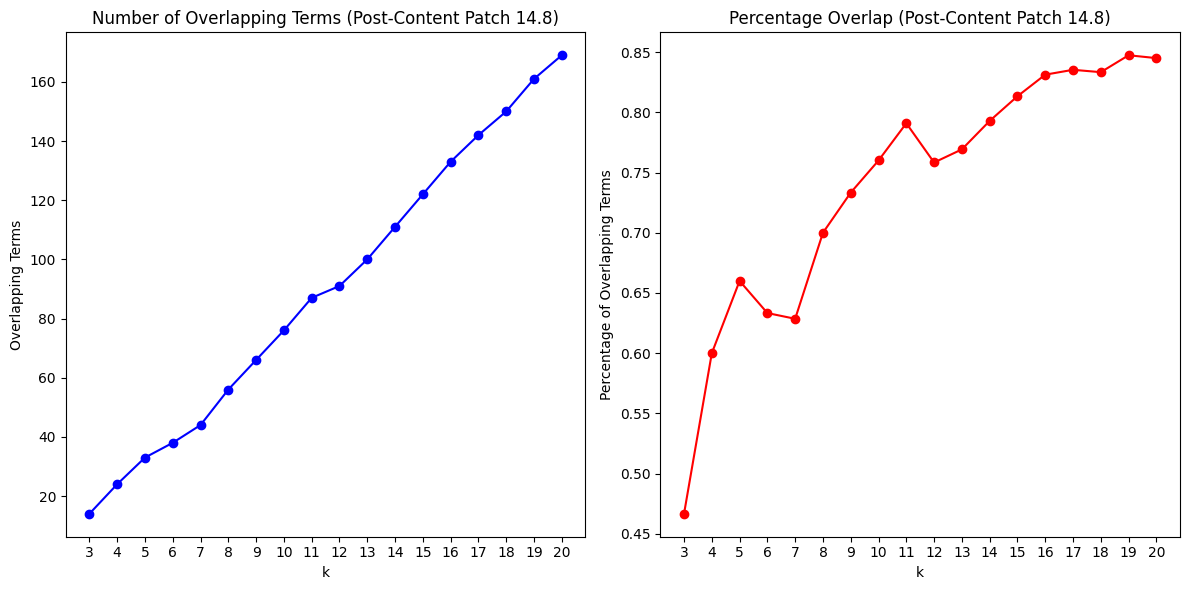

In [13]:
overlap_df = pd.DataFrame(columns=['k', 'duplicates', 'duplicates_per', 'duplicates_top'])

for it in range(18):
    k = 20 - it
    n_duplicates = 0
    top_five_string = ''
    order_centroids, terms = tf_idf_cluster(cleaned_self_posts_patch, k)

    columns = []
    for i in range(k):
        columns.append('Cluster ' + str(i))
    clusters_df = pd.DataFrame(columns=columns)

    for i in range(k):
            column = []
            for ind in order_centroids[i, :10]:
                column.append(terms[ind])
            clusters_df[columns[i]] = column

    clusters_df_terms = clusters_df.values.flatten().tolist()
    for term in clusters_df_terms:
        if clusters_df_terms.count(term) > 1:
            n_duplicates += 1

    counter = Counter(clusters_df_terms)
    top_five = counter.most_common(5)
    for tup in top_five:
        tup_string = (str(tup[0]) + ': ' + str(tup[1]) + ', ')
        top_five_string += tup_string
    top_five_string = top_five_string[:-2]

    new_data = {
                'k': k,
                'duplicates': n_duplicates,
                'duplicates_per': (n_duplicates / len(clusters_df_terms)),
                'duplicates_top': top_five_string
    }

    new_row = pd.DataFrame([new_data])
    overlap_df = pd.concat([overlap_df, new_row], ignore_index=True)

overlap_df['k'] = overlap_df['k'].astype(int)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First line chart for duplicates
axes[0].plot(overlap_df['k'], overlap_df['duplicates'], marker='o', color='b')
axes[0].set_title('Number of Overlapping Terms (Post-Content Patch 14.8)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Overlapping Terms')
axes[0].set_xticks(overlap_df['k']) 

# Second line chart for duplicates percentage
axes[1].plot(overlap_df['k'], overlap_df['duplicates_per'], marker='o', color='r')
axes[1].set_title('Percentage Overlap (Post-Content Patch 14.8)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Percentage of Overlapping Terms')
axes[1].set_xticks(overlap_df['k']) 

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
overlap_df

,k,duplicates,duplicates_per,duplicates_top
0,20,169,0.845000,"like: 19, play: 13, game: 11, playing: 9, know: 8"
1,19,161,0.847368,"like: 18, play: 13, game: 11, know: 9, time: 9"
2,18,150,0.833333,"like: 17, play: 12, game: 11, know: 9, time: 8"
3,17,142,0.835294,"like: 16, play: 11, game: 10, time: 9, playing: 8"
4,16,133,0.831250,"like: 15, game: 10, time: 9, play: 8, know: 7"
5,15,122,0.813333,"like: 15, play: 9, game: 8, time: 8, know: 6"
6,14,111,0.792857,"like: 13, game: 9, play: 8, time: 8, know: 7"
7,13,100,0.769231,"like: 11, good: 9, game: 6, playing: 5, want: 5"
8,12,91,0.758333,"like: 11, game: 6, good: 6, playing: 5, want: 5"
9,11,87,0.790909,"like: 10, good: 7, time: 5, think: 5, want: 5"


### TF-IDF Patch-Specific Title Analysis 

In [15]:
k = 6
columns = ['Patch']

for i in range(k):
     columns.append(('Cluster ' + str(i)))
patch_clusters_df = pd.DataFrame(columns=columns)

for it in range(reddit_posts[reddit_posts['Patch'] != 0]['Patch'].nunique()):
    post_titles = reddit_posts[reddit_posts['Patch'] == reddit_posts[reddit_posts['Patch'] != 0]['Patch'].unique()[it]]['Title'].tolist()
    cleaned_post_titles = clean_texts(post_titles)
    order_centroids, terms = tf_idf_cluster(cleaned_post_titles, k)

    columns = []
    for i in range(k):
        columns.append('Cluster ' + str(i))
    clusters_df = pd.DataFrame(columns=columns)

    for i in range(k):
            column = []
            for ind in order_centroids[i, :10]:
                column.append(terms[ind])
            clusters_df[columns[i]] = column
    new_data = [reddit_posts[reddit_posts['Patch'] != 0]['Patch'].unique()[it]]
    for colit in range(k):
        term_string = ", ".join(clusters_df.iloc[:, colit].tolist())
        new_data.append(term_string)
    patch_clusters_df.loc[len(patch_clusters_df)] = new_data

patch_clusters_df = patch_clusters_df.sort_values(by='Patch')
patch_clusters_df.reset_index(drop=True, inplace=True)
patch_clusters_df

,Patch,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,14.1,"cinematic, season, league, new, kindred, league legends, legends, morgana, lol, aatrox","new, game, good, item, items, support, play, vs, builds, think","build, new, best, ap, whats, good, bruiser, think, support, lethality","ad, build, ap, shaco, new, bruiser, builds, best, season, item","season, new season, new, build, items, good, guide, penta, builds, support","skin, like, new, best, got, yasuo, riot, think, main, art"
1,14.2,"play, ahri, game, vs, support, adc, yasuo, good, finally, mid","new, skin, game, good, season, like, vs, support, got, item","build, best, new, bruiser, support, tank, ad, item, lethality, season","love, champ, playing, new, game, fun, hydra, like, guys, feels","buff, nerf, sett, got, patch, pbe, riot, lol, think, better","bug, ult, pbe, new, patch, champion, item, time, playing, guys"
2,14.3,"new, play, game, support, good, like, mid, urf, help, think","build, best, new, ap, urf, support, game, ad, damage, jungle","finally, got, hit, diamond, years, emerald, main, happy, skins, buff","league, legends, league legends, champion, years, today, day, wild, like, patch","vs, matchup, ap, play, lane, illaoi, riven, mid, patch, yorick","skin, prestige, new, best, riot, rift, wild, want, like, art"
3,14.4,"build, skin, new, game, play, vs, good, support, like, main","art, splash art, splash, chroma, legends, league, league legends, evelynn, porcelain, high","items, build, tank, runes, item, support, new, love, ap, guys","need, help, buffs, guys, like, know, damage, play, game, really","think, guys, build, good, know, game, damage, really, changes, new","champ, fun, love, lane, play, mains, good, main, make, like"
4,14.5,"guys, think, playing, like, main, jungle, new, need, help, got","build, best, ap, new, jungle, shaco, damage, support, fun, mid","skin, play, new, game, support, vs, like, art, playing, got","riot, skin, game, games, riven, buff, bug, buffs, getting, just","good, build, yone, play, vs, champ, game, jungle, bad, skin","lane, mid, adc, game, win, matchup, tips, build, advice, need"
5,14.6,"new, skin, play, game, skarner, like, got, mid, good, best","rework, skarner, got, thoughts, like, ult, want, new, playing, best","build, best, new, mid, jungle, ap, game, help, items, tank","art, sett, battle, champion, skarner, like, high noon, noon, team, wild rift","support, playing, item, build, game, best, items, adc, main, play","vs, game, play, build, yone, lane, item, yasuo, garen, darius"
6,14.7,"game, build, new, vs, play, support, good, like, lane, playing","buff, changes, gwen, patch, does, make, need, skarner, rework, like","skarner, new skarner, new, rework, build, like, old, bad, support, feels","guys, think, know, play, game, got, playing, build, skin, like","skin, new, best, prestige, empyrean, old, think, like, kayle, champion","main, new, yone, master, support, garen, help, adc, build, playing"
7,14.8,"new, player, arena, pbe, gameplay, build, main, need, skarner, best","game, build, play, vs, support, league, best, good, playing, mid","like, feel, play, skin, game, new, playing, skarner, guys, lane","skin, new, prestige, best, empyrean, think, calligraphia, know, yasuo, whats","jungle, skarner, build, support, item, ranked, nerfs, main, game, master","yone, skin, yasuo, high, mid, got, vs, elo, just, good"


In [16]:
patch_terms_df = pd.DataFrame(columns=['Patch', 'Terms'])
for row in range(patch_clusters_df.shape[0]):
    new_data = [patch_clusters_df.iloc[row, 0]]
    new_data.append(", ".join(list(set(str(", ".join(patch_clusters_df.iloc[row, 1:])).split(',')))))
    patch_terms_df.loc[len(patch_terms_df)] = new_data
patch_terms_df

,Patch,Terms
0,14.1,"morgana, guide, item, like, aatrox, kindred, season, cinematic, game, builds, skin, league, lethality, ap, support, legends, whats, ad, bruiser, good, new season, vs, shaco, got, main, build, think, league legends, items, riot, penta, lol, new, art, play, yasuo, best"
1,14.2,"adc, guys, buff, ult, item, like, play, ahri, season, better, bug, nerf, game, time, skin, lethality, feels, patch, support, love, ad, bruiser, hydra, good, vs, tank, champ, got, build, fun, think, riot, lol, sett, playing, pbe, mid, finally, new, champion, yasuo, best"
2,14.3,"buff, want, day, like, years, hit, jungle, damage, game, skins, today, diamond, wild, skin, league, ap, new, support, patch, legends, illaoi, ad, happy, good, rift, vs, help, emerald, got, main, lane, build, think, league legends, matchup, riot, mid, finally, new, urf, riven, prestige, yorick, art, play, champion, best"
3,14.4,"make, guys, item, splash art, like, need, buffs, chroma, damage, game, skin, league, ap, support, love, legends, evelynn, mains, high, build, good, vs, tank, runes, know, help, champ, splash, porcelain, main, lane, build, think, league legends, items, fun, really, changes, new, art, play"
4,14.5,"adc, buff, just, like, need, buffs, jungle, damage, bug, game, skin, bad, ap, getting, support, games, win, guys, good, vs, advice, help, shaco, champ, got, main, lane, build, think, fun, matchup, riot, playing, mid, new, riven, yone, art, tips, play, best"
5,14.6,"adc, want, ult, item, like, yasuo, thoughts, high noon, jungle, wild rift, game, skin, ap, new, support, garen, good, vs, tank, team, help, darius, got, skarner, main, lane, build, battle, items, noon, sett, playing, mid, new, yone, art, rework, play, champion, best"
6,14.7,"make, guys, kayle, game, buff, master, adc, old, like, need, new skarner, game, empyrean, skin, bad, feels, patch, support, garen, gwen, good, does, vs, know, help, got, skarner, main, lane, build, think, playing, changes, prestige, new, yone, rework, play, champion, best"
7,14.8,"master, guys, item, just, like, need, nerfs, jungle, feel, game, empyrean, skin, calligraphia, league, elo, new, support, whats, gameplay, yone, high, good, player, vs, know, got, skarner, arena, main, lane, build, think, playing, pbe, mid, prestige, new, ranked, play, yasuo, best"


In [17]:
patch_unique_terms_df = pd.DataFrame(columns=['Patch', 'Unique Terms'])
count = Counter(",".join(list(patch_terms_df.iloc[:, 1])).replace(' ', '').split(','))
duplicates = [item for item, cnt in count.items() if cnt > 1]

for row in range(patch_terms_df.shape[0]):
    new_data = [patch_terms_df.iloc[row, 0]]
    row_terms = patch_terms_df.iloc[row, 1].replace(' ', '').split(',')
    row_terms = ", ".join(list(filter(lambda x: x not in duplicates, row_terms)))
    new_data.append(row_terms)
    patch_unique_terms_df.loc[len(patch_unique_terms_df)] = new_data

patch_unique_terms_df

,Patch,Unique Terms
0,14.1,"morgana, guide, aatrox, kindred, cinematic, builds, newseason, penta"
1,14.2,"ahri, better, nerf, time, hydra"
2,14.3,"day, years, hit, skins, today, diamond, wild, illaoi, happy, rift, emerald, urf, yorick"
3,14.4,"splashart, chroma, evelynn, mains, runes, splash, porcelain, really"
4,14.5,"getting, games, win, advice, tips"
5,14.6,"thoughts, highnoon, wildrift, team, darius, battle, noon"
6,14.7,"kayle, old, newskarner, gwen, does"
7,14.8,"nerfs, feel, calligraphia, elo, gameplay, player, arena, ranked"


In [18]:
common_terms = set(patch_terms_df['Terms'].tolist()[0].split(', '))

for s in patch_terms_df['Terms'].tolist()[1:]:
    common_terms.intersection_update(s.split(', '))

print('Common Terms:')
print(common_terms)

Common Terms:
{' build', ' game', ' like', ' good', ' vs', ' skin', ' new', ' support'}


### TF-IDF Patch-Specific Title+Content Analysis 

In [19]:
post_contents_df = reddit_posts[(reddit_posts['Patch'] != 0) & (reddit_posts['Is Self-post'] == True)].copy()
post_contents_df.loc[:, 'Full Content'] = post_contents_df['Title'] + ' ' + post_contents_df['Content']

In [ ]:
k = 9
columns = ['Patch']

for i in range(k):
     columns.append(('Cluster ' + str(i)))
patch_clusters_df = pd.DataFrame(columns=columns)

for it in range(reddit_posts[reddit_posts['Patch'] != 0]['Patch'].nunique()):
    post_contents = reddit_posts[reddit_posts['Patch'] == reddit_posts[reddit_posts['Patch'] != 0]['Patch'].unique()[it]]['Content'].tolist()
    cleaned_post_contents = clean_texts(post_contents)
    order_centroids, terms = tf_idf_cluster(cleaned_post_contents, k)

    columns = []
    for i in range(k):
        columns.append('Cluster ' + str(i))
    clusters_df = pd.DataFrame(columns=columns)

    for i in range(k):
            column = []
            for ind in order_centroids[i, :100]:
                column.append(terms[ind])
            clusters_df[columns[i]] = column
    new_data = [reddit_posts[reddit_posts['Patch'] != 0]['Patch'].unique()[it]]
    for colit in range(k):
        term_string = ", ".join(clusters_df.iloc[:, colit].tolist())
        new_data.append(term_string)
    patch_clusters_df.loc[len(patch_clusters_df)] = new_data

patch_clusters_df = patch_clusters_df.sort_values(by='Patch')
patch_clusters_df.reset_index(drop=True, inplace=True)
patch_clusters_df

In [21]:
patch_terms_df = pd.DataFrame(columns=['Patch', 'Terms'])
for row in range(patch_clusters_df.shape[0]):
    new_data = [patch_clusters_df.iloc[row, 0]]
    new_data.append(", ".join(list(set(str(", ".join(patch_clusters_df.iloc[row, 1:])).split(',')))))
    patch_terms_df.loc[len(patch_terms_df)] = new_data
patch_terms_df

,Patch,Terms
0,14.1,"enemy, want, ult, nan, bit, feel like, feels, strong, getting, games, win, actually, vs, pretty, runes, ability, trying, right, main, playing, new, health, ive, play, champion, make, used, second, xb, passive, season, feel, dmg, lot, dont, love, early, hydra, good, champ, crit, lane, think, gold, building, hp, best, attack, guys, adc, need, going, game, kill, builds, people, bad, lethality, speed, try, champs, sure, help, know, ..."
1,14.2,"enemy, want, ult, nan, bit, elo, feel like, low, feels, strong, getting, games, win, actually, vs, pretty, runes, ability, right, main, playing, new, health, ive, play, champion, make, used, second, buff, pick, xb, passive, season, feel, dmg, lot, dont, love, long, early, started, good, champ, lane, think, gold, building, range, champions, hp, best, attack, guys, adc, need, going, game, kill, builds, skin, people, bad, speed, t..."
2,14.3,"enemy, want, ult, nan, bit, ve, elo, feel like, low, feels, strong, getting, games, win, actually, vs, pretty, thanks, runes, trying, right, main, playing, new, tips, ive, champion, play, make, used, pick, xb, passive, season, feel, dmg, lot, dont, love, long, early, started, good, champ, lane, think, gold, champions, skin, hp, best, attack, adc, guys, need, going, game, kill, builds, skin, people, bad, speed, try, high, champs..."
3,14.4,"enemy, want, ult, rate pick, nan, bit, elo, feel like, low, feels, getting, pick rate, games, win, actually, pretty, runes, ability, trying, right, main, playing, new, health, ive, play, champion, make, used, second, rate pick rate, pick, xb, passive, season, feel, lot, dont, love, early, good, build, champ, lane, win rate, think, gold, building, champions, hp, able, best, attack, guys, adc, need, going, game, kill, builds, skin, p..."
4,14.5,"enemy, want, ult, rate pick, nan, bit, people, feel like, low, feels, getting, pick rate, win, games, actually, vs, pretty, runes, trying, right, main, playing, new, ive, play, champion, make, used, second, rate pick rate, pick, xb, passive, season, feel, dmg, lot, dont, love, early, started, good, champ, lane, win rate, think, gold, looking, champions, hp, best, guys, adc, need, going, game, kill, builds, skin, people, bad, speed,..."
5,14.6,"enemy, want, ult, nan, bit, elo, feel like, low, feels, getting, games, win, actually, pretty, runes, ability, trying, right, skarner, main, say, playing, new, health, ive, play, champion, make, used, second, pick, xb, passive, season, feel, dmg, lot, shield, dont, love, long, early, good, champ, lane, win rate, think, gold, range, champions, hp, best, attack, adc, guys, need, going, game, kill, builds, skin, people, league, bad..."
6,14.7,"enemy, want, ult, nan, bit, elo, feel like, wave, feels, low, getting, games, win, actually, vs, pretty, ability, trying, skarner, right, main, playing, new, slow, ranked, ive, play, champion, make, used, second, pick, xb, passive, season, feel, lot, dont, love, long, early, started, good, champ, lane, think, gold, champions, able, hp, best, guys, adc, need, going, game, kill, skin, people, league, bad, speed, try, high, champs..."
7,14.8,"enemy, want, ult, nan, elo, feel like, low, feels, getting, win, games, actually, vs, pretty, ability, trying, right, main, say, playing, new, ranked, health, ive, play, champion, make, used, pick, xb, passive, season, feel, lot, dont, love, long, early, started, guys, good, champ, lane, think, gold, range, champions, hp, best, adc, guys, need, going, game, kill, skin, people, league, bad, speed, try, bot, high, champs, know, h..."


In [24]:
patch_unique_terms_df = pd.DataFrame(columns=['Patch', 'Unique Terms'])
count = Counter(",".join(list(patch_terms_df.iloc[:, 1])).replace(' ', '').split(','))
duplicates = [item for item, cnt in count.items() if cnt > 1]

for row in range(patch_terms_df.shape[0]):
    new_data = [patch_terms_df.iloc[row, 0]]
    row_terms = patch_terms_df.iloc[row, 1].replace(' ', '').split(',')
    row_terms = ", ".join(list(filter(lambda x: x not in duplicates, row_terms)))
    new_data.append(row_terms)
    patch_unique_terms_df.loc[len(patch_unique_terms_df)] = new_data

patch_unique_terms_df

,Patch,Unique Terms
0,14.1,"hydra, crit, lethality, far, great, armor, gives"
1,14.2,buff
2,14.3,"ve, thanks, tips, change"
3,14.4,patch
4,14.5,"looking, eq, eqeq, tell"
5,14.6,shield
6,14.7,"wave, slow, old"
7,14.8,"bot, wanted, instead"


In [25]:
# Export Unique Terms
patch_unique_terms_df.to_csv('unique_tf_idf_terms.csv', sep=';', index=False)

In [55]:
common_terms = set(patch_terms_df['Terms'].tolist()[0].split(', '))

for s in patch_terms_df['Terms'].tolist()[1:]:
    common_terms.intersection_update(s.split(', '))

print('Common Terms:')
print(list(common_terms))

Common Terms:
[' want', ' actually', ' guys', ' kill', ' hit', ' mid', ' game', ' got', ' really', ' played', ' ult', ' champion', ' xb', ' support', ' like', ' main', ' feel', ' use', ' make', ' going', ' love', ' feel like', ' hp', ' help', ' early', ' play', ' dont', ' item', ' know', ' enemy', ' maybe', ' nan', ' feels', ' team', ' playing', ' adc', ' ive', ' speed', ' level', ' games', ' bad', ' jungle', ' way', ' fun', ' items', ' people', ' better', ' ad', ' getting', ' pretty', ' used', ' new', ' think', ' try', ' season', ' build', ' damage', ' lane', ' time', ' win', ' gold', ' need', ' lot', ' champ', ' hard', ' champs', ' ap', ' usually', ' good', ' best', ' right', ' passive']
